# Preprocesamiento de Datos

En esta sección, cargamos los datos desde una base de datos SQLite y los preprocesamos para convertir las direcciones IP a enteros y normalizar los datos.

In [4]:
# Preprocesamiento de Datos
import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos desde SQLite
def load_data_from_db(db_name='network_traffic.db', table_name='traffic'):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

df_packets = load_data_from_db()

# Mostrar las primeras filas de los datos cargados
df_packets.head()

,protocol,src_addr,src_port,dst_addr,dst_port
0,TCP,162.159.133.234,443,192.168.1.11,38048
1,TCP,192.168.1.11,38048,162.159.133.234,443
2,TCP,140.82.113.25,443,192.168.1.11,48930
3,TCP,192.168.1.11,48930,140.82.113.25,443
4,TCP,140.82.113.25,443,192.168.1.11,48930


**Librerías**:

- pandas: Para manipulación y análisis de datos.
- sqlite3: Para interactuar con la base de datos SQLite.
- StandardScaler de sklearn: Para normalización de datos.
- matplotlib.pyplot y seaborn: Para visualización de datos.

**Carga de Datos**:

La función load_data_from_db se conecta a una base de datos SQLite, ejecuta una consulta SQL para seleccionar todos los datos de la tabla traffic y devuelve un DataFrame de pandas con los datos cargados.

**Visualización de Datos**:
Se muestran las primeras filas del DataFrame cargado con `df_packets.head()` para una inspección rápida de los datos.

# Análisis de Datos

Convertimos las direcciones IP a enteros y normalizamos las características relevantes, como `src_addr`, `dst_addr`, `src_port`, `dst_port` y `packet_size`. Luego, visualizamos la distribución de los datos preprocesados.

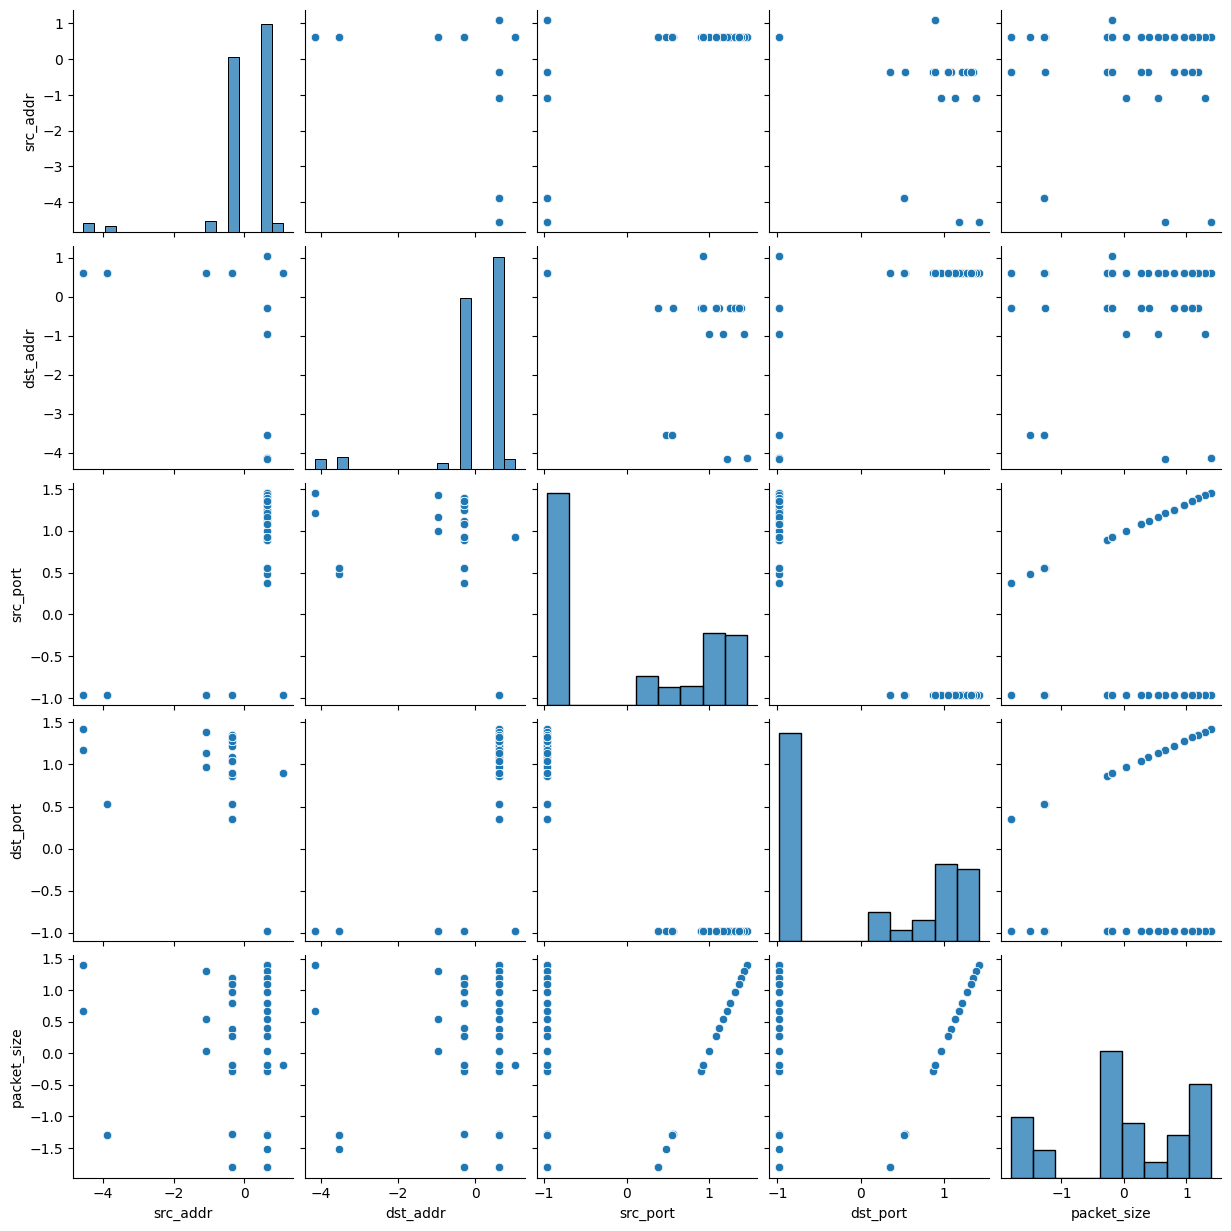

In [5]:
# Función para preprocesar los datos
def preprocess_data(df):
    # Convertir direcciones IP a enteros
    def ip_to_int(ip):
        try:
            return int(''.join(f'{int(i):08b}' for i in ip.split('.')), 2)
        except:
            return 0

    df['src_addr'] = df['src_addr'].apply(ip_to_int)
    df['dst_addr'] = df['dst_addr'].apply(ip_to_int)

    # Extraer características relevantes
    df['packet_size'] = df['src_port'] + df['dst_port']

    # Seleccionar solo las columnas numéricas
    numeric_columns = ['src_addr', 'dst_addr', 'src_port', 'dst_port', 'packet_size']

    # Llenar valores faltantes con la mediana
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    # Normalizar los datos
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[numeric_columns])

    return df_scaled

df_preprocessed = preprocess_data(df_packets)

# Visualizar la distribución de los datos preprocesados
sns.pairplot(pd.DataFrame(df_preprocessed, columns=['src_addr', 'dst_addr', 'src_port', 'dst_port', 'packet_size']))
plt.show()

**Conversión de Direcciones IP a Enteros**:

La función ip_to_int convierte las direcciones IP de su formato string a enteros para facilitar el análisis.

**Creación de Características**:

packet_size: Suma los valores de src_port y dst_port para obtener una medida del tamaño del paquete.

**Llenado de Valores Faltantes**:

Se llenan los valores faltantes en las columnas numéricas con la mediana de esas columnas.

**Normalización de Datos**:

Se utiliza StandardScaler para normalizar las características numéricas seleccionadas.

**Visualización**:

Se utiliza seaborn para crear un pairplot de las características normalizadas, lo que permite visualizar la distribución y relaciones entre las características.

# Entrenamiento de Modelos de Machine Learning

Generamos ejemplos de anomalías y aumentamos la proporción de anomalías en los datos de entrenamiento. Entrenamos el modelo Isolation Forest con diferentes parámetros de contaminación y evaluamos su rendimiento.

In [6]:
# Entrenamiento de Modelos de Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import numpy as np

# Aumentar la proporción de anomalías en los datos de entrenamiento
anomalies_train = np.random.uniform(low=-10, high=10, size=(100, df_preprocessed.shape[1]))  # Generar 100 ejemplos de anomalías
X_train_with_anomalies = np.vstack([df_preprocessed, anomalies_train])
y_train_with_anomalies = [0] * len(df_preprocessed) + [1] * 100

# Entrenamiento de Isolation Forest con diferentes parámetros de contaminación
def train_isolation_forest(X_train, contamination):
    model = IsolationForest(contamination=contamination)
    model.fit(X_train)
    return model

# Función para evaluar el modelo
from sklearn.metrics import classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(classification_report(y_test, y_pred))

# Generar datos de prueba incluyendo anomalías sintéticas
X_test_normal = df_preprocessed
y_test_normal = [0] * len(X_test_normal)

# Crear anomalías sintéticas (por ejemplo, valores fuera del rango normal)
anomalies = np.random.uniform(low=-10, high=10, size=(10, X_test_normal.shape[1]))
X_test_anomalies = np.vstack([X_test_normal, anomalies])
y_test_anomalies = y_test_normal + [1] * 10

# Probar diferentes valores de contaminación
for contamination in [0.05, 0.1, 0.15]:
    print(f"Evaluación de Isolation Forest con contaminación={contamination}:")
    isolation_forest_model = train_isolation_forest(X_train_with_anomalies, contamination)
    evaluate_model(isolation_forest_model, X_test_anomalies, y_test_anomalies)


Evaluación de Isolation Forest con contaminación=0.05:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       216
           1       1.00      0.30      0.46        10

    accuracy                           0.97       226
   macro avg       0.98      0.65      0.72       226
weighted avg       0.97      0.97      0.96       226

Evaluación de Isolation Forest con contaminación=0.1:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       216
           1       1.00      0.60      0.75        10

    accuracy                           0.98       226
   macro avg       0.99      0.80      0.87       226
weighted avg       0.98      0.98      0.98       226

Evaluación de Isolation Forest con contaminación=0.15:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       216
           1       1.00      0.80      0.89        10

    accuracy      

**Generación de Anomalías**:

Se generan 100 ejemplos de anomalías utilizando una distribución uniforme con valores entre -10 y 10. Estas anomalías se añaden a los datos de entrenamiento.

**Entrenamiento de Isolation Forest**:

La función train_isolation_forest entrena un modelo de Isolation Forest con un parámetro de contaminación específico, que indica la proporción de datos que se espera que sean anomalías.

**Evaluación del Modelo**:

La función evaluate_model utiliza classification_report de sklearn.metrics para evaluar el rendimiento del modelo y mostrar métricas como precision, recall y f1-score.

**Generación de Datos de Prueba**:

Se crean datos de prueba que incluyen anomalías sintéticas para evaluar los modelos.

**Entrenamiento y Evaluación con Diferentes Contaminaciones**:

Se entrena y evalúa el modelo de Isolation Forest con diferentes valores de contaminación (0.05, 0.1, 0.15) para observar cómo afecta al rendimiento del modelo.

# Entrenamiento de One-Class SVM

Entrenamos el modelo One-Class SVM con los datos aumentados.

In [7]:
# Entrenamiento de One-Class SVM
def train_one_class_svm(X_train, y_train):
    model = OneClassSVM(nu=0.1)
    model.fit(X_train)
    return model

one_class_svm_model = train_one_class_svm(X_train_with_anomalies, y_train_with_anomalies)

**Entrenamiento de One-Class SVM**:

La función train_one_class_svm entrena un modelo de One-Class SVM utilizando los datos de entrenamiento que incluyen anomalías. El parámetro `nu` controla la proporción de datos que se espera que sean anomalías.

# Evaluación de Modelos

Generamos datos de prueba, incluyendo anomalías sintéticas, y evaluamos los modelos entrenados utilizando métricas de clasificación como precision, recall y f1-score.

In [8]:
# Evaluación de Modelos

print("Evaluación de Isolation Forest con datos aumentados:")
evaluate_model(isolation_forest_model, X_test_anomalies, y_test_anomalies)

print("Evaluación de One-Class SVM con datos aumentados:")
evaluate_model(one_class_svm_model, X_test_anomalies, y_test_anomalies)

Evaluación de Isolation Forest con datos aumentados:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       216
           1       1.00      0.80      0.89        10

    accuracy                           0.99       226
   macro avg       1.00      0.90      0.94       226
weighted avg       0.99      0.99      0.99       226

Evaluación de One-Class SVM con datos aumentados:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       216
           1       1.00      0.80      0.89        10

    accuracy                           0.99       226
   macro avg       1.00      0.90      0.94       226
weighted avg       0.99      0.99      0.99       226



**Evaluación de Isolation Forest y One-Class SVM**:

Se evalúan ambos modelos utilizando los datos de prueba que incluyen anomalías sintéticas, y se muestran las métricas de clasificación (precision, recall y f1-score) para cada modelo.